<br>
<font>
<div dir=ltr align=center>
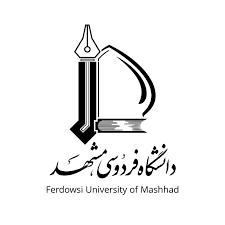
<br>
<font color=0F5298 size=8>
Implement Neural Networks from scratch <br>
<font color=696880 size=5>
<!-- <br> -->
Mathematics Sceince Department
<br>
Ferdowsi University of Mashhad

<font color=696880 size=5>
<br>
 Fall 2024

<font color=GREEN size=5>
<br>

<!-- <br> -->

In [1]:
# @title setup and imports

import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange
import ipywidgets as widgets
from IPython.display import display

In [2]:
# @title helper functions

def plot_training(losses):
    # Plot the loss
    plt.plot(losses)
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


def get_data(filter_classes):
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)
    # Remove classes
    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]
    # Normalize the pixels to be in [-1, +1] range
    x = ((x / 255.) - .5) * 2
    removed_class_count = 0
    for i in range(10):  # Fix the labels
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1
    # Do the train-test split
    return train_test_split(x, y, test_size=10_000)


def onehot_encoder(y, num_labels):
    one_hot = np.zeros(shape=(y.size, num_labels), dtype=int)
    one_hot[np.arange(y.size), y] = 1
    return one_hot


def plot_batch_size(vanila, stochastic, mini_batch):
    fig, axes = plt.subplots(2, 2)
    # Plot the loss
    axes[0, 0].plot(vanila[0], label='Gradient Descent')
    axes[0, 0].plot(stochastic[0], label='Stochastic Gradient Descent')
    axes[0, 0].plot(mini_batch[0], label='Mini-Batch Gradient Descent')
    axes[0, 0].set_xlabel('Epoch'), axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss'), axes[0, 0].legend()
    # Plot the accuracy
    axes[0, 1].plot(vanila[2], label='Gradient Descent')
    axes[0, 1].plot(stochastic[2], label='Stochastic Gradient Descent')
    axes[0, 1].plot(mini_batch[2], label='Mini-Batch Gradient Descent')
    axes[0, 1].set_xlabel('Epoch'), axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Test Accuracy'), axes[0, 1].legend()
    # Plot SGD batch loss
    axes[1, 0].plot(stochastic[1], label='Stochastic Gradient Descent')
    axes[1, 0].set_xlabel('Batch'), axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Stochastic Gradient Descent')
    # Plot MBGD batch loss
    axes[1, 1].plot(mini_batch[1], label='Mini-Batch Gradient Descent')
    axes[1, 1].set_xlabel('Batch'), axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Mini-Batch Gradient Descent')

    fig.set_size_inches(16, 12)
    plt.show()

# Layers

## Abstract Layer Class

The `Layer` class serves as an abstract base class for all layers in the network. It includes placeholder methods:
- `forward`: The forward pass computes the output of the layer given an input.
- `backward`: The backward pass computes the gradients with respect to the input and parameters.
- `step`: Updates the layer parameters (weights and biases).

In [3]:
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, lr: float) -> None:
        pass

## Linear Layers

The `Linear` class implements the fully connected (or dense) layer of a neural network, which performs a linear transformation on the input:

$$\mathbf{y} = \mathbf{x} \cdot \mathbf{W} + \mathbf{b}$$

**Initialization**
- `self.w`: Represents the weight matrix of shape `(in_dim, out_dim)`, initialized using small random values.
- `self.b`: Bias vector of shape `(1, out_dim)`, initialized to zeros.
- `self.dw` and `self.db`: These store the computed gradients of weights and biases during backpropagation.




**Forward Pass**
- The forward pass computes:
$$\mathbf{out} = \mathbf{inp} \cdot \mathbf{W} + \mathbf{b}$$
where:
  - `inp`: Input matrix of shape `(batch_size, in_dim)`
  - `self.w`: Weight matrix of shape `(in_dim, out_dim)`
  -	`self.b`: Bias matrix of shape `(1, out_dim)`
-	The result is a matrix out of shape `(batch_size, out_dim)`.




**Backward Pass**
- The backward pass computes gradients needed for updating the weights and biases. Given the upstream gradient `up_grad` (from the loss with respect to the output of this layer), we calculate:
  - Gradient w.r.t. weights (`self.dw`):
    $$ \frac{\partial L}{\partial W} = \mathbf{inp}^T \cdot \text{up_grad} $$
  - Gradient w.r.t. biases (`self.db`):
    $$\frac{\partial L}{\partial b} = \sum \text{up_grad} \text{ (summed across batch)}$$
  - Gradient to propagate to the previous layer (`down_grad`):
    $$\text{down_grad} = \text{up_grad} \cdot W^T$$
- This allows the gradient to flow backward to earlier layers.




**Step Method**
- Updates the weights and biases using the computed gradients and learning rate (`lr`):
    $$W = W - lr \cdot \frac{\partial L}{\partial W}$$
    $$b = b - lr \cdot \frac{\partial L}{\partial b}$$


In [4]:
class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        # He initialization: better scaling for deep networks
        self.w = 0.1 * np.random.randn(in_dim, out_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform the linear transformation: output = inp * W + b"""
        self.inp = inp
        self.out = np.dot(inp, self.w) + self.b
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backpropagate the gradients through this layer."""
        # Compute gradients for weights and biases
        self.dw = np.dot(self.inp.T, up_grad)  # Gradient wrt weights
        self.db = np.sum(up_grad, axis=0, keepdims=True)  # Gradient wrt biases
        # Compute gradient to propagate back (downstream)
        down_grad = np.dot(up_grad, self.w.T)
        return down_grad

    def step(self, lr: float) -> None:
        """Update the weights and biases using the gradients."""
        self.w -= lr * self.dw
        self.b -= lr * self.db

## Activation Functions

We can implement activation functions as layers. This will simplify the training process

### Sigmoid

- The Sigmoid function is defined as follows:

$$f(x) = \frac{1}{1 + e^{-x}}$$

- Sigmoid squashes the input into the range [0, 1], making it useful for binary classification tasks.
- It converts any real-valued number into a probability-like output.
- However, in deeper networks, it may cause vanishing gradients due to its flat slope for extreme values.
- The derivative of Sigmoid is convenient to compute using its output  $f(x)$:
$$f'(x) = \frac{-e^{-x}}{(1 + e^{-x})^2} = \frac{1}{1 + e^{-x}} \cdot \frac{e^{-x}}{1 + e^{-x}} = f(x) \cdot (1-f(x))$$

In [5]:
class Sigmoid(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Sigmoid Activation: f(x) = 1 / (1 + exp(-x))"""
        self.out = 1 / (1 + np.exp(-inp))
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Sigmoid: f'(x) = f(x) * (1 - f(x))"""
        down_grad = self.out * (1 - self.out) * up_grad
        return down_grad

### ReLU (Rectified Linear Unit)

- The ReLU function outputs 0 if the input is less than zero, otherwise it will return the input itself:
$$f(x) = \max(0,x) $$

- ReLU helps introduce non-linearity into the model, which is essential for learning complex patterns.
- It also helps avoid the vanishing gradient problem common in deep networks with the Sigmoid activation.
- During backpropagation, only the gradients for inputs greater than 0 pass through:

$$ f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$


In [6]:
class ReLU(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """ReLU Activation: f(x) = max(0, x)"""
        self.inp = inp
        self.out = np.maximum(0, inp)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for ReLU: derivative is 1 where input > 0, else 0."""
        down_grad = up_grad * (self.inp > 0)  # Efficient boolean indexing
        return down_grad

### Softmax

- The Softmax function is defined as follows:
$$f(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

- Softmax normalizes the input values into probabilities that sum to 1.
- It's typically used in the final layer of a neural network for multi-class classification.
- It converts raw scores into probabilities, where each class has a non-negative probability between 0 and 1.
- Subtracting the maximum input value (`np.max(inp)`) from all inputs before applying `np.exp` helps prevent overflow errors.

In [7]:
class Softmax(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Softmax Activation: f(x) = exp(x) / sum(exp(x))"""
        # Subtract max for numerical stability
        exp_values = np.exp(inp - np.max(inp, axis=1, keepdims=True))
        self.out = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Softmax using the Jacobian matrix."""
        down_grad = np.empty_like(up_grad)
        for i in range(up_grad.shape[0]):
            single_output = self.out[i].reshape(-1, 1)
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            down_grad[i] = np.dot(jacobian, up_grad[i])
        return down_grad

# Loss Functions

## Abstract Loss Class

The `Loss` class serves as an abstract base class for all layers in the network. It includes placeholder methods:
- `forward`: To compute the loss given predictions and targets.
- `backward`: To compute the loss given predictions and targets.

In [8]:
class Loss:
    def __init__(self):
        self.prediction = None
        self.target = None
        self.loss = None

    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)

    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError

    def backward(self) -> np.ndarray:
        raise NotImplementedError

## Cross-Entropy Loss

Cross-entropy loss is typically used in classification tasks since it measures the dissimilarity between the true distribution (target) and the predicted probability distribution (prediction):

$$L = - \frac{1}{N} \sum_{i} \sum_{c} y_{ic} \log(p_{ic})$$

where $y_{ic}$ is the one-hot encoded true label (target), $p_{ic}$ is the predicted probability (output from Softmax) and $N$ is the batch size.


In [9]:
class CrossEntropy(Loss):
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Cross-Entropy Loss for classification."""
        self.prediction = prediction
        self.target = target
        # Clip predictions to avoid log(0)
        clipped_pred = np.clip(prediction, 1e-12, 1.0)
        # Compute and return the loss
        self.loss = -np.mean(np.sum(target * np.log(clipped_pred), axis=1))
        return self.loss

    def backward(self) -> np.ndarray:
        """Gradient of Cross-Entropy Loss."""
        # Gradient wrt prediction (assuming softmax and one-hot targets)
        grad = -self.target / self.prediction / self.target.shape[0]
        return grad

## Mean Squared Error (MSE) Loss

MSE is used primarily for regression tasks, where you need to measure the distance between the predicted continuous values and the true values:

$$L = \frac{1}{N} \sum_{i} (p_i - y_i)^2$$

where $p_i$ is the predicted value, $y_i$ is the true value (target) and $N$ is the batch size.

The gradient measures the difference between the prediction and the target, scaled by the batch size:

$$\frac{\partial L}{\partial p_i} = \frac{2}{N} (p_i - y_i)$$


In [10]:
class MSE(Loss):
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Mean Squared Error Loss for regression."""
        self.prediction = prediction
        self.target = target
        # Compute and return the loss
        self.loss = np.mean((prediction - target) ** 2)
        return self.loss

    def backward(self) -> np.ndarray:
        """Gradient of MSE Loss."""
        grad = 2 * (self.prediction - self.target) / self.target.size
        return grad

# Neural Network

Now we can combine everything we've done earlier to build a neural network class called `MLP` with the following methods:

- `forward`: Sequentially passes input through each layer in the network to compute the output.
- `loss`: Computes the loss between the predicted output and the true target using the specified loss function.
- `backward`: Propagates the gradient from the loss function through each layer, updating the gradients of the parameters in each layer.
- `update`: Updates each layer's parameters (e.g., weights and biases) using the gradients computed during backpropagation.
- `train`: Executes the training loop for a specified number of epochs, iterating over the dataset in mini-batches, performing the forward pass, computing the loss, backpropagating the gradients, and updating the parameters.


In [11]:
class MLP:
    def __init__(self, layers: list[Layer], loss_fn: Loss, lr: float) -> None:
        """
        Multi-Layer Perceptron (MLP) class.
        Arguments:
        - layers: List of layers (e.g., Linear, ReLU, etc.).
        - loss_fn: Loss function object (e.g., CrossEntropy, MSE).
        - lr: Learning rate.
        """
        self.layers = layers
        self.loss_fn = loss_fn
        self.lr = lr

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        """Makes the model callable, equivalent to forward pass."""
        return self.forward(inp)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Pass input through each layer sequentially."""
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Calculate the loss."""
        return self.loss_fn(prediction, target)

    def backward(self) -> None:
        """Perform backpropagation by propagating the gradient backwards through the layers."""
        up_grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            up_grad = layer.backward(up_grad)

    def update(self) -> None:
        """Update the parameters of each layer using the gradients and the learning rate."""
        for layer in self.layers:
            layer.step(self.lr)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int) -> np.ndarray:
        """Train the MLP over the given dataset for a number of epochs."""
        losses = np.empty(epochs)
        for epoch in (pbar := trange(epochs)):
            running_loss = 0.0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Forward pass
                prediction = self.forward(x_batch)

                # Compute loss
                running_loss += self.loss(prediction, y_batch) * batch_size

                # Backward pass
                self.backward()

                # Update parameters
                self.update()

            # Normalize running loss by total number of samples
            running_loss /= len(x_train)
            pbar.set_description(f"Loss: {running_loss:.3f}")
            losses[epoch] = running_loss

        return losses

# Training

## Loading the Fashion-MNIST Dataset

For simplicity you can use `get_data` to load the Fashion-MNIST dataset. Since we aren't using GPUs, in order to save time and get better results, we are only going to include 3 classes in our training. However you can easily modify this cell to include different classes.

In [12]:
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Include all the classes you want to see in training
kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker

# Download the dataset and split it into training and testing sets
x_train, x_test, y_train, y_test = get_data(kept_classes)

# One-hot encode the target labels of the training set
y_train = onehot_encoder(y_train, num_labels=len(kept_classes))

## Training the Network

Now we can define the network and train it on the dataset.

  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.055: 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


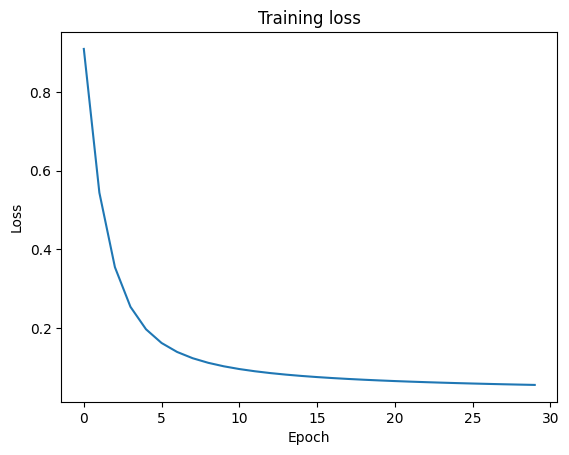

In [13]:
# Define the layers of the neural network
layers = [Linear(784, 50),
          ReLU(),
          Linear(50, 50),
          ReLU(),
          Linear(50, len(kept_classes)),
          Softmax()]

# Create the model
model = MLP(layers, CrossEntropy(), lr=0.001)

# Train the model
losses = model.train(x_train, y_train, epochs=30, batch_size=64)

# Plot the training loss curve
plot_training(losses)

## Evaluation

We can measure the models accuracy on the test dataset.

In [14]:
# Test the model
y_prediction = np.argmax(model(x_test), axis=1)
acc = 100 * np.mean(y_prediction == y_test)
print(f'Test accuracy with {len(y_train)} training examples on {len(y_test)} test samples is {acc:.2f}%')

Test accuracy with 11000 training examples on 10000 test samples is 98.37%


The confusion matrix can also be observed:

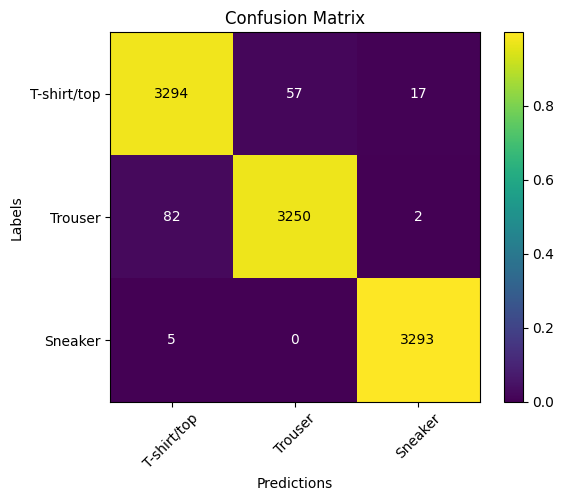

In [15]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_prediction, class_names, kept_classes)

# Experiments

In this section we are going to run some experiments to better understand the different hyperparameters of our neural network.
We will slightly modify the `MLP` class we wrote before to access different metrics during training.

In [16]:
# @title Modified MLP

class NN(MLP):
    def test(self, x_test: np.ndarray, y_test: np.ndarray) -> float:
        """Calculate the test accuracy and return it."""
        y_pred = np.argmax(self.forward(x_test), axis=1)
        return 100 * np.mean(y_pred == y_test)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int,
              batch_size: int, x_test: np.ndarray, y_test: np.ndarray) -> np.ndarray:
        """Train the MLP over the given dataset for a number of epochs."""
        losses = np.zeros(epochs)
        batch_count = len(x_train) // batch_size
        batch_losses = np.empty(epochs * batch_count + 1)
        accuracies = np.empty(epochs)

        for epoch in (pbar := trange(epochs)):
            correct = 0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                # Forward pass
                prediction = self.forward(x_batch)
                # Compute loss
                batch_losses[i // batch_size + epoch * batch_count] = self.loss(prediction, y_batch)
                losses[epoch] += batch_losses[i // batch_size + epoch * batch_count]
                # Backward pass
                self.backward()
                # Update parameters
                self.update()

            # Display and update the metrics
            losses[epoch] /= batch_count
            accuracies[epoch] = self.test(x_test, y_test)
            pbar.set_description(f"Train Loss = {losses[epoch]:.3f} | Test Accuracy = {accuracies[epoch]:.2f}% ")

        return losses, batch_losses, accuracies

## Batch Size

Here we will take a look at different batch sizes and how they effect training and convergence. Run the widget bellow to train the model for different batch sizes!

In [17]:
# @markdown Batch Size Experimentation Widget

class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Include all the classes you want to see in training
kept_classes = [0, 1, 7]  # T-shirt/top, Trouser, Sneaker

# Download the dataset and split it into training and testing sets
x_train, x_test, y_train, y_test = get_data(kept_classes)

# One-hot encode the target labels of the training set
y_train = onehot_encoder(y_train, num_labels=len(kept_classes))

# Create a list of values
options = [16, 32, 64, 128, 256]

# Create a dropdown widget with custom layout
dropdown = widgets.Dropdown(
    options=options,
    description='Batch Size:',
    layout={'width': '200px'},
)

# Define a function to run based on selected value
def on_value_change(change):
    mini_batch_size = change['new']
    global first_run, gd, sgd, mbgd
    if first_run:
        # Gradient Descent
        layers = [Linear(784, 50), ReLU(), Linear(50, 50), ReLU(), Linear(50, len(kept_classes)), Softmax()]
        model = NN(layers, CrossEntropy(), lr=0.001)
        print('Gradient Descent:', end='\n\t')
        gd = model.train(x_train, y_train, epochs=30, batch_size=len(x_train), x_test=x_test, y_test=y_test)
        # Mini-Batch Gradient Descent
        layers = [Linear(784, 50), ReLU(), Linear(50, 50), ReLU(), Linear(50, len(kept_classes)), Softmax()]
        model = NN(layers, CrossEntropy(), lr=0.001)
        print('Stochastic Gradient Descent:', end='\n\t')
        sgd = model.train(x_train, y_train, epochs=30, batch_size=1, x_test=x_test, y_test=y_test)
        first_run = False
    else:
        print('\n')
    # Stochastic Gradient Descent
    layers = [Linear(784, 50), ReLU(), Linear(50, 50), ReLU(), Linear(50, len(kept_classes)), Softmax()]
    model = NN(layers, CrossEntropy(), lr=0.001)
    print('Mini-Batch Gradient Descent:', end='\n\t')
    mbgd = model.train(x_train, y_train, epochs=30, batch_size=mini_batch_size, x_test=x_test, y_test=y_test)
    print()
    plot_batch_size(gd, sgd, mbgd)



# Observe changes in the dropdown value
dropdown.observe(on_value_change, names='value')

# Run Vanila Gradient Descent and Stochastic Gradient Descent once
first_run = True

gd, sgd, mbgd = None, None, None

# Display the widget
display(dropdown)

Dropdown(description='Batch Size:', layout=Layout(width='200px'), options=(16, 32, 64, 128, 256), value=16)

As you can see, increasing the batch size improves the speed of our algorithm, while reducing the batch size allows us to achieve higher accuracies.